In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime
import pandas as pd
from utils import MONTH_NAMES_RU
from collections import defaultdict

era5_path = '../data/prepare/era5_ice/'
noaa_ice_path = '../data/prepare/noaa_ice/'
figures_dir = "../figures/prepare/ice/"

os.makedirs(figures_dir, exist_ok=True)

In [2]:
def process_file(file, date, prefix):
    filepath = os.path.join(prefix, file)
    if not os.path.exists(filepath):
        return []
    ds = xr.open_dataset(filepath, engine="h5netcdf")
    val = ds.ice.to_numpy()
    ds.close()
    return [date, np.sum(val > 0)]

def process_date(file):
    date = datetime.strptime(file[:8], "%Y%m%d")
    noaa_ice_stat = process_file(file, date, noaa_ice_path)
    era5_stat = process_file(file, date, era5_path)

    result = []
    if noaa_ice_stat:
        result.append(noaa_ice_stat + ['noaa_ice'])
    if era5_stat:  
        result.append(era5_stat + ['era5'])

    return result

files = [f for f in os.listdir(era5_path)]
monthly_mean = defaultdict(lambda: np.zeros((361, 1440), dtype=np.float64))

with ProcessPoolExecutor() as executor:
    stats = list(tqdm(executor.map(process_date, files), total=len(files)))
    stats = [item for outer in stats for item in outer]
    stats_df = pd.DataFrame(stats, columns=["date", "count", "archive"])
    stats_df['month'] = stats_df['date'].dt.month
    era5_df = stats_df[stats_df['archive'] == 'era5']
    noaa_ice_df = stats_df[stats_df['archive'] == 'noaa_ice']

  0%|          | 0/12714 [00:00<?, ?it/s]

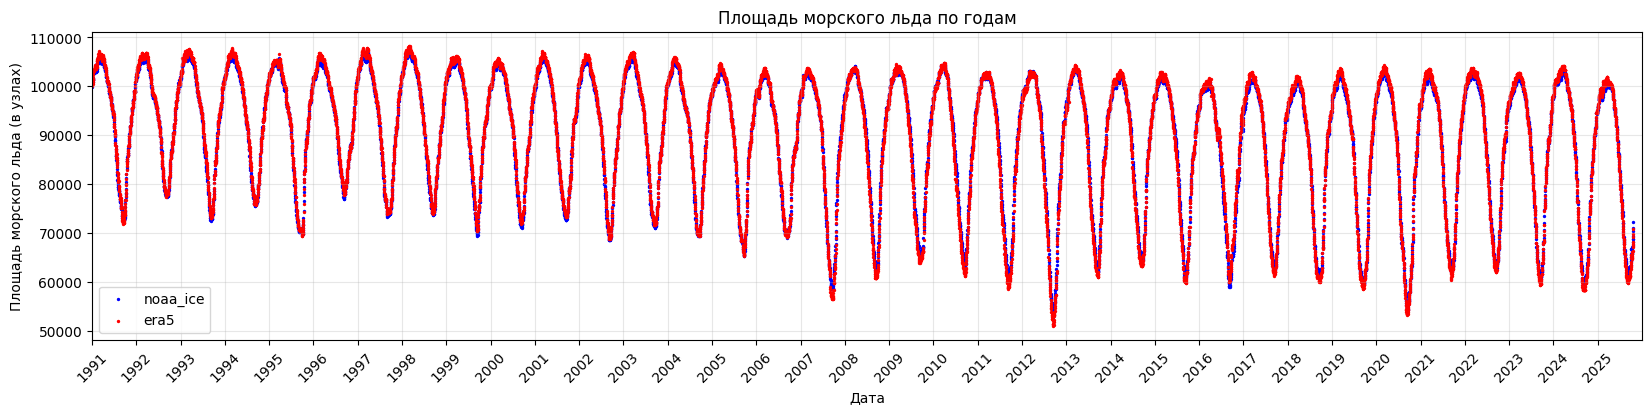

In [3]:
years = range(1991, 2026)

plt.figure(figsize=(20, 4))
plt.scatter(noaa_ice_df["date"], noaa_ice_df["count"], s=2, c='b')
plt.scatter(era5_df["date"], era5_df["count"], s=2, c='r')
plt.xlabel("Дата")
plt.ylabel("Площадь морского льда (в узлах)")
plt.title("Площадь морского льда по годам")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.xticks([pd.Timestamp(year, 1, 1) for year in years], years)
plt.xlim([pd.Timestamp(1991, 1, 1), pd.Timestamp(2026, 1, 1)])
plt.legend(['noaa_ice', 'era5'])
plt.savefig(figures_dir + 'cover_by_years.png', dpi=150, bbox_inches='tight')
plt.show()

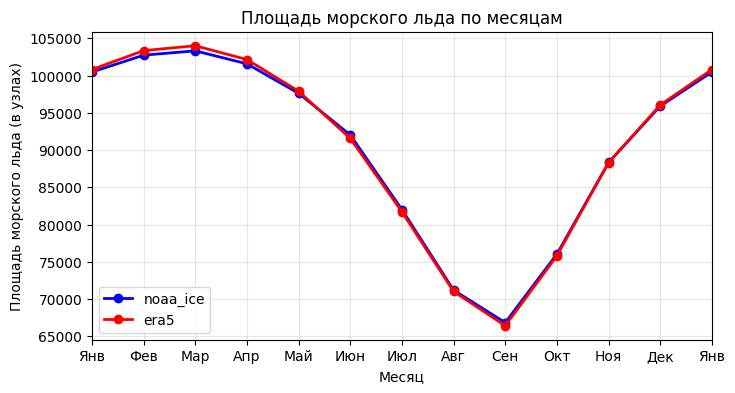

In [4]:
noaa_ice_monthly_mean = noaa_ice_df.groupby('month').agg({'count': 'mean'})
noaa_ice_monthly_mean = pd.concat([noaa_ice_monthly_mean, noaa_ice_monthly_mean.loc[[1]].rename({1: 13})])
era5_monthly_mean = era5_df.groupby('month').agg({'count': 'mean'})
era5_monthly_mean = pd.concat([era5_monthly_mean, era5_monthly_mean.loc[[1]].rename({1: 13})])

plt.figure(figsize=(8, 4))
plt.plot(noaa_ice_monthly_mean.index, noaa_ice_monthly_mean['count'], marker='o', linewidth=2, color='b')
plt.plot(era5_monthly_mean.index, era5_monthly_mean['count'], marker='o', linewidth=2, color='r')
plt.xlabel("Месяц")
plt.ylabel("Площадь морского льда (в узлах)")
plt.title("Площадь морского льда по месяцам")
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 14), MONTH_NAMES_RU + [MONTH_NAMES_RU[0]])
plt.xlim(1, 13)
plt.legend(['noaa_ice', 'era5'])
plt.savefig(figures_dir + 'cover_by_months.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
def process_month_archive(month, files, archive):
    if len(files) == 0:
        return

    figures_achive_dir = os.path.join(figures_dir, archive)
    os.makedirs(figures_achive_dir, exist_ok=True)

    mean = np.zeros((361, 1440))
    for i, file in enumerate(files):
        if i % 100 == 0:
            print(f"{archive}, {month}: {i+1}/{len(files)}")
        ds = xr.open_dataset(file, engine="h5netcdf")
        mean += ds.ice.to_numpy()
        if i == 0:
            lat = ds.lat.to_numpy()
            lon = ds.lon.to_numpy()
        ds.close()

    mean /= len(files)

    fig, ax = plt.subplots(figsize=(12, 6))
    levels = np.linspace(0, 1, 101)
    contour = ax.contourf(lon, lat, mean, levels, cmap='Blues')
    cb = fig.colorbar(contour)
    cb.set_label('Доля льда')
    month_name = MONTH_NAMES_RU[month-1]
    ax.set_title(f'Средняя доля морского льда, {archive}, {month_name}')
    ax.set_xlabel('Долгота')
    ax.set_ylabel('Широта')
    fig.savefig(os.path.join(figures_achive_dir, f"month_{month}.png"), dpi=150, bbox_inches='tight')
    plt.close(fig)

def process_month(data):
    noaa_ice_files, era5_files = data[1]
    process_month_archive(data[0], noaa_ice_files, "noaa_ice")
    process_month_archive(data[0], era5_files, "era5")

files_by_month = defaultdict(lambda: ([], []))
for file in os.listdir(noaa_ice_path):
    date = datetime.strptime(file[:8], "%Y%m%d")
    files_by_month[date.month][0].append(os.path.join(noaa_ice_path, file))
for file in os.listdir(era5_path):
    date = datetime.strptime(file[:8], "%Y%m%d")  
    files_by_month[date.month][1].append(os.path.join(era5_path, file)) 

with ProcessPoolExecutor() as executor:
    executor.map(process_month, list(files_by_month.items()))

noaa_ice, 1: 1/1085noaa_ice, 7: 1/1085noaa_ice, 10: 1/1076noaa_ice, 9: 1/1050noaa_ice, 4: 1/1049
noaa_ice, 6: 1/1050


noaa_ice, 3: 1/1085noaa_ice, 2: 1/989noaa_ice, 8: 1/1085noaa_ice, 11: 1/1020


noaa_ice, 5: 1/1085noaa_ice, 12: 1/1054




noaa_ice, 5: 101/1085
noaa_ice, 11: 101/1020
noaa_ice, 6: 101/1050
noaa_ice, 3: 101/1085
noaa_ice, 12: 101/1054
noaa_ice, 9: 101/1050
noaa_ice, 4: 101/1049
noaa_ice, 2: 101/989
noaa_ice, 1: 101/1085
noaa_ice, 7: 101/1085
noaa_ice, 10: 101/1076
noaa_ice, 8: 101/1085
noaa_ice, 5: 201/1085
noaa_ice, 10: 201/1076
noaa_ice, 4: 201/1049
noaa_ice, 9: 201/1050
noaa_ice, 1: 201/1085
noaa_ice, 2: 201/989
noaa_ice, 6: 201/1050
noaa_ice, 8: 201/1085
noaa_ice, 11: 201/1020
noaa_ice, 12: 201/1054
noaa_ice, 7: 201/1085
noaa_ice, 3: 201/1085
noaa_ice, 5: 301/1085
noaa_ice, 9: 301/1050
noaa_ice, 10: 301/1076
noaa_ice, 1: 301/1085
noaa_ice, 4: 301/1049
noaa_ice, 12: 301/1054
noaa_ice, 7: 301/1085
noaa_ice, 2: 301/989
noaa_ice, 6: 301/1050
noaa_ice, 3: 301/1085
noaa_